In [5]:
import numpy as np
import matplotlib.pyplot as  plt
import pandas as pd
from math import log,sqrt,exp
from scipy import stats

In [6]:
#根据公式计算期权价值
def bsm_call_value(s0,k,t,r,sigma):
    d1 = ( log( s0/k ) + ( r + 0.5*sigma**2 )*t )/( sigma*sqrt(t) )
    d2 = ( log( s0/k ) + ( r - 0.5*sigma**2 )*t )/( sigma*sqrt(t) )
    value = ( s0*stats.norm.cdf( d1,0.,1. ) - k*exp( -r*t )*stats.norm.cdf( d2,0.,1 ))
    #print('cvalue',value)
    return value

#求vega
def bsm_vega(s0,k,t,r,sigma):
    d1 = log( s0/k ) + ( r + 0.5*sigma**2 )*t/( sigma*sqrt(t) )
    vega = s0*stats.norm.cdf(d1,0.,1.)*sqrt(t)
    #print('vega',vega)
    return vega

#牛顿迭代法求隐含波动率，迭代次数设为100
def bsm_call_imp_vol_newton(s0, k, t, r, c0, sigma_est, it = 100):    
    for i in range(it):
        sigma_est -= ((bsm_call_value(s0, k, t, r, sigma_est) - c0)/ 
                      bsm_vega(s0, k, t, r, sigma_est))
    return sigma_est

In [7]:
#二分法求隐含波动率
def bsm_call_imp_vol_dichotomy(s0,k,t,r,c):
    c_est = 0
    top = 3  #波动率上限
    floor = 0  #波动率下限
    sigma = ( floor + top )/2 #波动率初始值
    
    while abs( c - c_est ) > 1e-8:
        c_est = bsm_call_value(s0,k,t,r,sigma) 
        #根据价格判断波动率是被低估还是高估，并对波动率做修正
        if c - c_est > 0: #f(x)>0
            floor = sigma
            sigma = ( sigma + top )/2
        else:
            top = sigma
            sigma = ( sigma + floor )/2
    return sigma 


In [11]:
#读取行情数据
call_50etf_16 = pd.read_csv('D:\\data\\options\\call_50etf_16.csv',encoding='utf-8')
call_50etf_51 = pd.read_csv('D:\\data\\options\\call_50etf_51.csv',encoding='utf-8')
call_50etf_79 = pd.read_csv('D:\\data\\options\\call_50etf_79.csv',encoding='utf-8')

#取期权价格和行权价
price_16 = call_50etf_16['最新价']
k_16 = call_50etf_16['行权价']
price_51 = call_50etf_51['最新价']
k_51 = call_50etf_51['行权价']
price_79 = call_50etf_79['最新价']
k_79 = call_50etf_79['行权价']

#到期时间年化
t_16 = 16/365
t_51 = 51/365
t_79 = 79/365

#标的初始价格
s0 = 2.533
#无风险利率，用shibor近似
rf = 0.025


In [10]:
#用两种方法分别求三只期权的隐含波动率，并打印
sigma_init=1
sigma_16_newton=[]
sigma_16_dichotomy=[]
for i in range(call_50etf_16.shape[0]):
    sigma_16_newton.append(bsm_call_imp_vol_newton(s0,k_16[i],t_16,rf,price_16[i],sigma_init))
    sigma_16_dichotomy.append(bsm_call_imp_vol_dichotomy(s0,k_16[i],t_16,rf,price_16[i]))
    
print('imp_vol_newton_16:')
print(sigma_16_newton)
print('imp_vol_dichotomy_16:')
print(sigma_16_dichotomy)
print('-------------------------------------------------------------------------------------------------------------------------------------')
#
sigma_51_newton=[]
sigma_51_dichotomy=[]
for i in range(call_50etf_51.shape[0]):
    sigma_51_newton.append(bsm_call_imp_vol_newton(s0,k_51[i],t_51,rf,price_51[i],sigma_init))
    sigma_51_dichotomy.append(bsm_call_imp_vol_dichotomy(s0,k_51[i],t_51,rf,price_51[i]))

print('imp_vol_newton_51:')    
print(sigma_51_newton)
print('imp_vol_dichotomy_51:')
print(sigma_51_dichotomy)
print('-------------------------------------------------------------------------------------------------------------------------------------')

#
sigma_79_newton=[]
sigma_79_dichotomy=[]
for i in range(call_50etf_79.shape[0]):
    sigma_79_newton.append(bsm_call_imp_vol_newton(s0,k_79[i],t_79,rf,price_79[i],sigma_init))
    sigma_79_dichotomy.append(bsm_call_imp_vol_dichotomy(s0,k_79[i],t_79,rf,price_79[i]))

print('imp_vol_newton_79:')     
print(sigma_79_newton)
print('imp_vol_dichotomy_79:')
print(sigma_79_dichotomy)
print('-------------------------------------------------------------------------------------------------------------------------------------')


imp_vol_newton_16:
[0.3638689603157307, 0.3647065048442553, 0.33796965226626546, 0.3087508280418194, 0.29010352112059345, 0.27704783086782625, 0.2678504434116786, 0.27958298121452063, 0.2815159982582914, 0.2892477867510613, 0.2948778490238011, 0.3001603015476018, 0.3079952199130588]
imp_vol_dichotomy_16:
[0.3638690114021301, 0.3647065758705139, 0.33796969056129456, 0.3087505102157593, 0.290103480219841, 0.2770475149154663, 0.2678511142730713, 0.2795829623937607, 0.28151603043079376, 0.2892477214336395, 0.29487812519073486, 0.3001604676246643, 0.30799537897109985]
-------------------------------------------------------------------------------------------------------------------------------------
imp_vol_newton_51:
[0.2663830055838, 0.2623349770104388, 0.25886692974504383, 0.25514765329363565, 0.25388257585478174, 0.25112748137747243, 0.25311127192458244, 0.25282431711916714, 0.25334527303228827]
imp_vol_dichotomy_51:
[0.26638298481702805, 0.26233501732349396, 0.25886694341897964, 0.2551

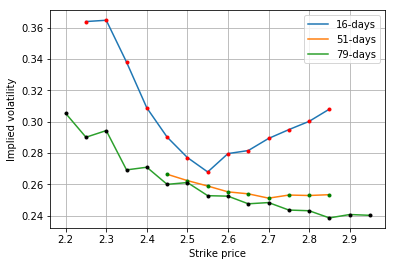

In [6]:
#绘制牛顿法求解的波动率曲线
plt.plot(k_16,sigma_16_newton,label='16-days',lw=1.5,)
plt.plot(k_16,sigma_16_newton,'r.')
plt.plot(k_51,sigma_51_newton,label='51-days',lw=1.5)
plt.plot(k_51,sigma_51_newton,'g.')
plt.plot(k_79,sigma_79_newton,label='79-days',lw=1.5)
plt.plot(k_79,sigma_79_newton,'k.')

plt.grid(True)
plt.xlabel('Strike price')
plt.ylabel('Implied volatility')
plt.legend()
plt.show()

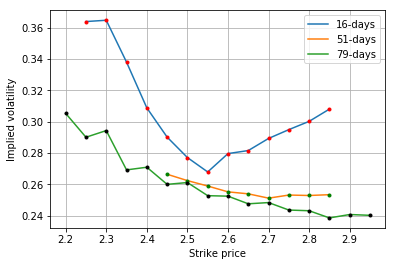

In [7]:
#绘制二分法求解的波动率曲线
plt.plot(k_16,sigma_16_dichotomy,label='16-days',lw=1.5,)
plt.plot(k_16,sigma_16_dichotomy,'r.')
plt.plot(k_51,sigma_51_dichotomy,label='51-days',lw=1.5)
plt.plot(k_51,sigma_51_dichotomy,'g.')
plt.plot(k_79,sigma_79_dichotomy,label='79-days',lw=1.5)
plt.plot(k_79,sigma_79_dichotomy,'k.')

plt.grid(True)
plt.xlabel('Strike price')
plt.ylabel('Implied volatility')
plt.legend()
plt.show()

[0.2848400904069232, 0.2842367078839068, 0.2827011409660353, 0.2790832314148648, 0.2797722610218441, 0.2751046357764691]
[0.28484009113162756, 0.28423671051859856, 0.2827011412009597, 0.2790832305327058, 0.2797722602263093, 0.27510463539510965]
###############


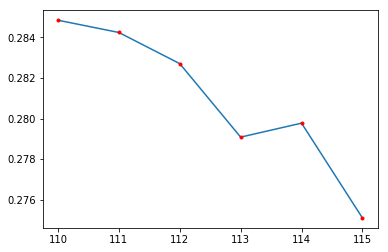

In [110]:
call_ms_16 = pd.read_csv('D:\\data\\options\\call_ms_16.csv',encoding='utf-8')

price_ms_16=call_ms_16['最新价']
k_ms_16=call_ms_16['执行']

s0=112.35

sigma_init=1
sigma_16_newton=[]
sigma_16_dichotomy=[]
for i in range(call_ms_16.shape[0]):
    sigma_16_newton.append(bsm_call_imp_vol_newton(s0,k_ms_16[i],t_16,rf,price_ms_16[i],sigma_init))
    sigma_16_dichotomy.append(bsm_call_imp_vol_dichotomy(s0,k_ms_16[i],t_16,rf,price_ms_16[i]))
print(sigma_16_newton)
print(sigma_16_dichotomy)
print('###############')
plt.plot(k_ms_16,sigma_16_dichotomy,label='16-days',lw=1.5,)
plt.plot(k_ms_16,sigma_16_dichotomy,'r.')





0.29000000639091406
0.29
0.15310000044057803
0.1531
0.002399991555676495
0.0024


In [81]:
for i in range(call_50etf_16.shape[0]):
    sigma_16_newton.append(bsm_call_imp_vol(s0,k_16[i],t_16,rf,price_16[i],sigma_init))
print(sigma_16_newton)
print('###############')
#

for i in range(call_50etf_51.shape[0]):
    sigma_51_newton.append(bsm_call_imp_vol(s0,k_51[i],t_51,rf,price_51[i],sigma_init))
print(sigma_51_newton)
print('###############')

#

for i in range(call_50etf_79.shape[0]):
    sigma_79_newton.append(bsm_call_imp_vol(s0,k_79[i],t_79,rf,price_79[i],sigma_init))
print(sigma_79_newton)


[0.36386969983929796, 0.36470650510148267, 0.3379696522663533, 0.308750828041821, 0.2901035211205926, 0.2770478308678258, 0.2678504434116783, 0.2795829812145216, 0.2815159982582912, 0.2892477867510631, 0.29487784902377207, 0.29826737962723826, 0.2737745536488281, 0.3638689603157307, 0.3647065048442553, 0.33796965226626546, 0.3087508280418194, 0.29010352112059345, 0.27704783086782625, 0.2678504434116786, 0.27958298121452063, 0.2815159982582914, 0.2892477867510613, 0.2948778490238011, 0.3001603015476018, 0.3079952199130588, 0.3638689603157307, 0.3647065048442553, 0.33796965226626546, 0.3087508280418194, 0.29010352112059345, 0.27704783086782625, 0.2678504434116786, 0.27958298121452063, 0.2815159982582914, 0.2892477867510613, 0.2948778490238011, 0.3001603015476018, 0.3079952199130588]
###############
[0.2663830055838007, 0.2623349770104382, 0.25886692974504427, 0.2551476532936361, 0.2538825758547821, 0.2511274813774724, 0.25311127192458355, 0.25282431711916775, 0.2533452730322892, 0.266383

ValueError: x and y must have same first dimension, but have shapes (13,) and (26,)

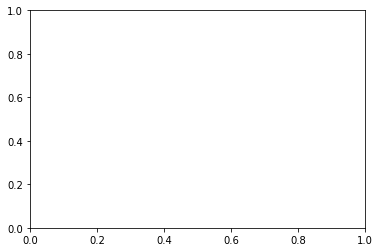

In [79]:
plt.plot(k_16,sigma_16_newton,label='16-days',lw=1.5,)
plt.plot(k_16,sigma_16_newton,'r.')
plt.plot(k_51,sigma_51_newton,label='51-days',lw=1.5)
plt.plot(k_51,sigma_51_newton,'g.')
plt.plot(k_79,sigma_79_newton,label='79-days',lw=1.5)
plt.plot(k_79,sigma_79_newton,'k.')

plt.grid(True)
plt.xlabel('Strike price')
plt.ylabel('Implied volatility')
plt.legend()
plt.show()